# Week 8 - Decision Trees

<hr style="border:2px solid gray">

# Outline

1. [Section One: Introduction to Decision Trees](#section-one-introduction-to-decision-trees)
1. [Section Two: Why not basic Decision Trees?](#section-two-why-not-basic-decision-trees)
1. [Section Three: Ensemble Learning and Random Forests](#section-three-ensemble-learning-and-random-forests)
1. [Section Four: Boosted Decision Trees (BDTs)](#section-four-boosted-decision-trees-bdts)
1. [Section Five: Exercises](#section-five-exercises)

<hr style="border:2px solid gray">

# Section One: Introduction to Decision Trees[^](#outline)

So far, we have discussed a couple algorithms we can use for both classification and regression but only really one algorithm that learns parameters in a meaningful way, which was the support vector machine. This week, we are going to introduce another type of model called **decision trees**.

When we pass our inputs to a decision tree, we go down the tree. The tree is made of **nodes** and **branches**; at each node, we examine one of our features and compare it to some threshold value. If our input feature is greater than the threshold, we go down the left branch, otherwise we go down the right. Eventually, we reach a node with no branches, called a **leaf node**. Leaf nodes are where we make a prediction: either a class label, for a classification problem, or a target value, for a regression problem. 

The specific choices we make to partition our data are made when we train the algorithm, and depends on whether we are solving a classification or regression problem. We will discuss each of these respectively.

## Decision Trees for classification



In classification, we want to be able to separate our data into different classes. When we train a decision tree for classification, we want to minimise how many splits we need to make, to make sure evaluation is as fast as possible. To do this, we want to make the most efficient possible splits of our data, i.e. split the training data into each class such that at each split, we separate as many samples of one class as possible from the other classes. 

We can understand this a bit better by using an `sklearn` example, which outputs nice graphs showing the structure of our decision tree. We will use the IRIS dataset to demonstrate this.

As always, we will first load the dataset and split it into training and test sets.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris['data'],iris['target'], test_size = 0.2, random_state = 20) # Keep same random state for consistency


Now we have loaded our data, we will define and fit a decision tree classifier. For now we will set the value of the hyperparameter `max_depth = 2`, and we will discuss (and other hyperparameters) later. 

In [3]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth = 2)

clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

We will now calculate the prediction on the test data, calculate the prediction accuracy, and plot a representation of the decision tree.

In [4]:
from sklearn.metrics import accuracy_score

pred = clf.predict(X_test)
print(accuracy_score(y_test, pred))

0.9


[Text(0.4, 0.8333333333333334, 'x[2] <= 2.6\ngini = 0.666\nsamples = 120\nvalue = [42, 39, 39]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 42\nvalue = [42, 0, 0]'),
 Text(0.6, 0.5, 'x[3] <= 1.65\ngini = 0.5\nsamples = 78\nvalue = [0, 39, 39]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.051\nsamples = 38\nvalue = [0, 37, 1]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.095\nsamples = 40\nvalue = [0, 2, 38]')]

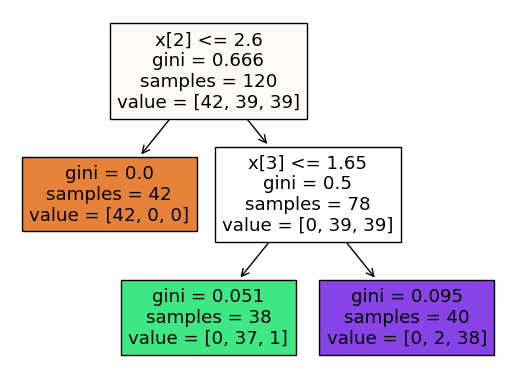

In [5]:
tree.plot_tree(clf, filled = True)

This diagram shows the structure of our decision tree. Each box is a node where a decision is made, based on some criteria on the input features. Each node lists the following characteristics of that node:

* The decision criteria at that node, e.g. the first node looks at feature `X[3]` (the petal width) and makes a decision based on whether it is greater or less than 0.8.
<br>

* The value of the **Gini impurity**, which tells you how good your separation at that node is. We will discuss this in more detail later.
<br>

* The total number of samples going into that node
<br>

* The number of samples in each class, e.g. in the first node we have 42 in the first class, 39 in the second, and 39 in the third. 

We can talk about three different kinds of node:

* The **root node** is the first node of the decision tree
<br>

* **Internal nodes** (or sometimes just nodes) are nodes with branches to and away from them
<br>

* A **leaf** is a node at the end of a branch, with no further branches. This is where we make a prediction.


When we train a decision tree, we determine the number of nodes and what the criteria at each node should be. The algorithm continues dividing the data with more nodes until it sees there is no point (i.e. the existing splits are good enough and more splits won't improve prediction on training data), or it has reached the maximum depth you allow it to reach (the `max_depth` hyperparameter we mentioned earlier).

For our example decision tree, for the leaf on the left the algorithm has identified that no more splits are necessary, as we have only one class left at that leaf. However, for the two nodes on the right at the bottom, while the splits are not perfect (multiple classes are present on both of the leaf nodes), the algorithm has reached its maximum depth of 2 and so has stopped splitting.

When it comes to making predictions using a trained decision tree, we compare the test sample input features to the cuts at each node and move down the tree until we reach a leaf. Finally, the prediction we make at a leaf is the most common class in the training data at that leaf.

### Choosing cut positions

In general, the cut positions are chosen to optimise some function of the model prediction on training data. For classification, we need some function that quantifies how good our data split is, i.e. how well it separates our different classes. One of the most common choices is the **Gini impurity**, which is given as

\begin{equation*}
G_i = 1 - \sum_k p_{i, k}^2,
\end{equation*}
where $G_i$ is the Gini impurity of node $i$ and $p_{i, k}$ is the probability of selecting a sample with class $k$ if we select a random sample at node $i$. 

We can see this as a measure of how likely we are to get a prediction wrong at a given node, if we randomly label a randomly selected sample:

* The probability of randomly selecting a sample of class $k$ at node $i$ is equal to $p_{i, k}$
<br>

* The probability of randomly selecting the label $k$ at node $i$ to assign to this sample is also $p_{i, k}$
<br>

* The probability of randomly selecting a sample with true class $k$ *and* randomly assigning it the class $k$ is therefore $p_{i, k}^2$ 
<br>

The sum $\sum_k p_{i, k}^2$ is therefore the total probability of correctly labelling a randomly selected sample with a randomly selected label at node $i$, so the Gini impurity $G_i$ is the probability of incorrectly labelling a randomly selected sample. 

This is the choice of loss function for a decision tree. There is an alternative option we can use, called the **log loss** or the **entropy**:

\begin{equation*}
H_i = -\sum_k p_{i, k}\log_2\left(p_{i,k}\right)
\end{equation*}

The entropy of given node is 0 if it only has samples of one class. 

Regardless of which loss function we use, the model decides on the the cut at each node by minimising the loss function for that node. Nodes are added iteratively and the cut at each node is optimised until the the decision tree algorithm reaches some stopping condition. This stopping condition could either be that the set of splits is determined to be as good as it can be, or it could be some requirement on the size of the tree (like the maximum depth we have already mentioned). 

There are a number of algorithms that can be used to build a decision tree once you have chosen your loss function. `sklearn` uses the Classification and Regression Tree (CART) algorithm. This is a so-called *greedy* algorithm, because it tries to make the best possible split at every step. You can find some more details on Decision Tree algorithms in the `sklearn` [documentation](https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart) and in **{homl}**. 

<div style="background-color:#FFCCCB">

### Mathematical formalism of decision trees

In this section, we follow the convention used in the `sklearn` [documentation](https://scikit-learn.org/stable/modules/tree.html#mathematical-formulation).

We will consider $l$ training data points with some arbitrary number of input features $n$ each, such that we can write the $i$-th training input and target as $X_i \in \mathcal{R}^n$ and $y_i$ respectively. We wish to construct a decision tree that recursively partitions the feature space, such that the samples with the same labels (or similar target values in the case of regression) are grouped together.

We will define the following:

* $Q_m$: the dataset at node $m$, which has $n_m$ samples
<br>

* A candidate (possible) split of the dataset $\theta = (j, t_m)$, consisting of a feature $j$ and a threshold $t_m$

We then partition the data into two subsets, which we denote as $Q_m^{\text{left}}(\theta)$ and $Q_m^{\text{right}}(\theta)$ respectively. These are defined according to:

\begin{align*}
Q_m^\text{left}(\theta) &= {(X, y) | x_j \leq t_m} \qquad \text{i.e. the set of (x, y) pairs that obey the condition the }j\text{-th feature of }X \leq t_m \\
Q_m^\text{right}(\theta) &= Q_m \backslash  Q_m^\text{left}(\theta) \qquad\quad\, \text{i.e. all (x, y) pairs in }Q_m\text{ that are not in }Q_m^\text{left}(\theta)
\end{align*}

The quality of a candidate split for a node $m$ is evaluated using a loss function, which we will denote as $H$. The loss function is a function of the choice a data set $Q$. The specific choice of this function depends on the task we are trying to solve (classification or regression). We can then denote the **quality** of a candidate split according to

\begin{equation*}
G(Q_m, \theta) = \frac{n_m^\text{left}}{n_m}H(Q_m^\text{left}(\theta)) + \frac{n_m^\text{right}}{n_m}H(Q_m^\text{right}(\theta)),
\end{equation*}
where $G(Q_m, \theta)$ is the quality of the candidate split $\theta$, and $n_m^\text{left}$ and $n_m^\text{right}$ denote the number of samples in the left and right subsets $Q_m^\text{left}(\theta)$ and $Q_m^\text{right}(\theta)$ respectively.

We wish to minimise the function $G$ to maximise the quality of the split, so we choose the split such that 

\begin{equation*}
\theta^* = \argmin_\theta G(Q_m, \theta), 
\end{equation*}
where $\theta^*$ is the split we choose and $\argmin_\theta G$ means we find the argument $\theta$ that minimises the function $G$.

We repeat this process for new candidate splits at each node until the maximum allowable depth is reached, $n_m \lt \min_\text{samples}$, or $n_m = 1$.


## Decision trees for regression

While they are most commonly used for classification, decision trees can also be applied to regression problems. In this case, the value predicted at a leaf node is either the mean or the median of the dataset at that leaf, depending on the chocie of loss function to train the decision tree. We will demonstrate this using an order 2 polynomial dataset.

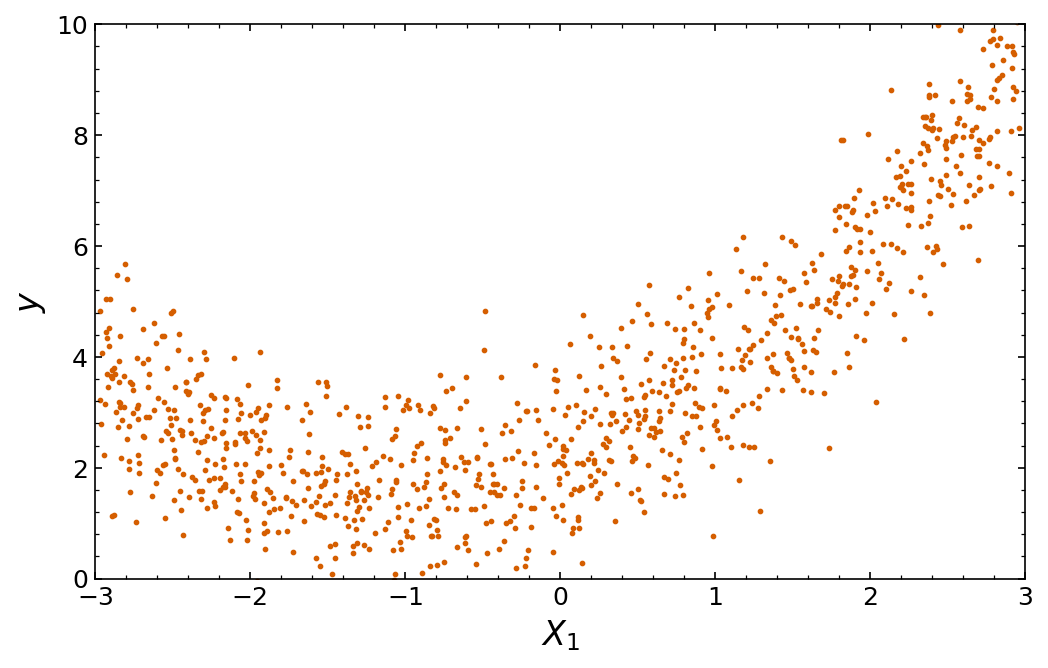

In [6]:
from matplotlib.ticker import MultipleLocator

np.random.seed(42) # Set the seed for consistency

X = 6*np.random.rand(1000,1) - 3
y = 0.5*X**2 + X + 2 + np.random.randn(1000,1)

fig, ax = plt.subplots(1,1,figsize = (8,24/5),dpi = 150)
ax.scatter(X,y,color='#D55E00',s = 3)
ax.set_xlabel('$X_1$',fontsize = 16)
ax.set_ylabel('$y$',fontsize = 16)
ax.set_xlim(-3,3)
ax.set_ylim(0,10)
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(0.4))
ax.tick_params(direction='in',top=True,right=True,labelsize = 12,which='both')


We will use the `DecisionTreeRegressor` from `sklearn`, which we can train on this data and then predict across the (-3,3) range. We will plot the result.

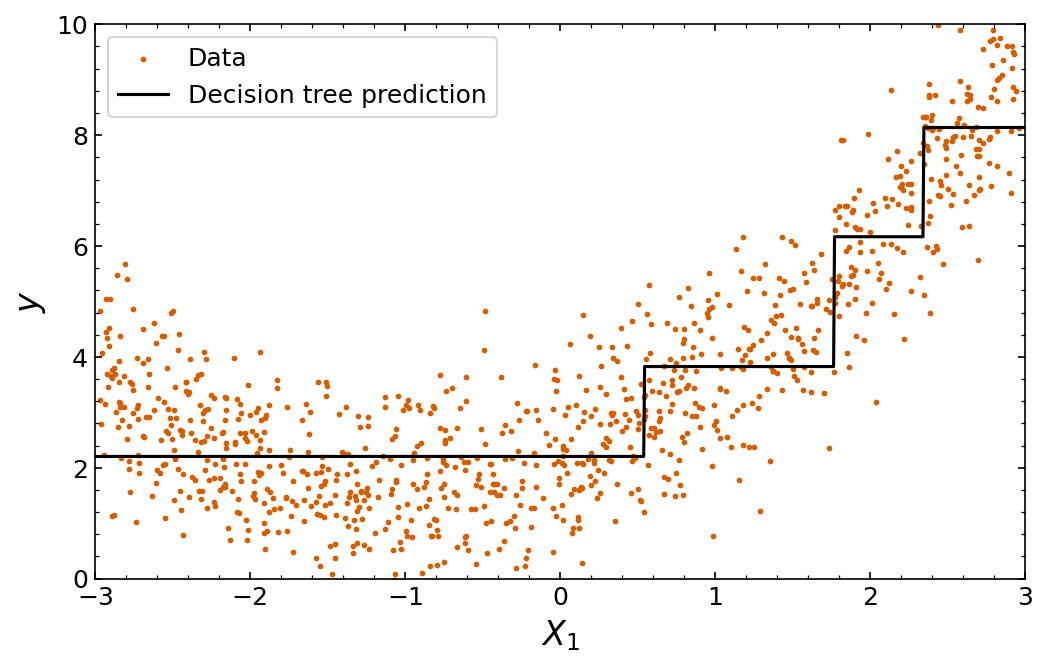

In [7]:
reg = tree.DecisionTreeRegressor(max_depth = 2)
reg.fit(X,y)

xs = np.linspace(-3,3,1000)

fig, ax = plt.subplots(1,1,figsize = (8,24/5),dpi = 150)
ax.scatter(X,y,color='#D55E00',s = 3, label = 'Data')

ys = reg.predict(xs.reshape(-1,1))
ax.plot(xs, ys, color='black',label='Decision tree prediction')

ax.set_xlabel('$X_1$',fontsize = 16)
ax.set_ylabel('$y$',fontsize = 16)
ax.set_xlim(-3,3)
ax.set_ylim(0,10)
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(0.4))
ax.tick_params(direction='in',top=True,right=True,labelsize = 12,which='both')
ax.legend(loc='upper left',fontsize = 12)


What exactly is going on here? The prediction function of the decision tree regressor is a step-like function, where each flat region corresponds to one of the datasets found by the splits in the decision tree, and the value of $y$ in this region is the mean of all of the training data in that dataset. We can then plot the decision tree:

[Text(0.5, 0.8333333333333334, 'x[0] <= 1.767\nsquared_error = 5.463\nsamples = 1000\nvalue = 3.577'),
 Text(0.25, 0.5, 'x[0] <= 0.542\nsquared_error = 1.729\nsamples = 791\nvalue = 2.598'),
 Text(0.125, 0.16666666666666666, 'squared_error = 1.257\nsamples = 599\nvalue = 2.205'),
 Text(0.375, 0.16666666666666666, 'squared_error = 1.207\nsamples = 192\nvalue = 3.827'),
 Text(0.75, 0.5, 'x[0] <= 2.345\nsquared_error = 2.257\nsamples = 209\nvalue = 7.28'),
 Text(0.625, 0.16666666666666666, 'squared_error = 1.149\nsamples = 91\nvalue = 6.168'),
 Text(0.875, 0.16666666666666666, 'squared_error = 1.421\nsamples = 118\nvalue = 8.138')]

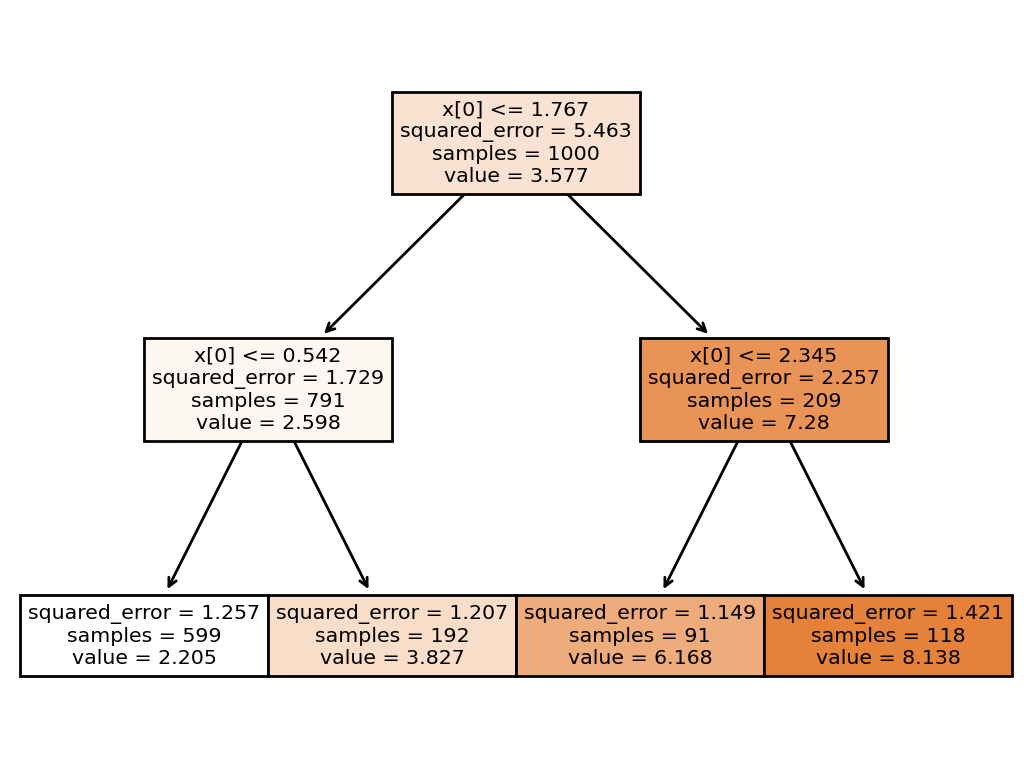

In [8]:
fig = plt.figure(dpi = 200)
tree.plot_tree(reg, filled = True)


As you can see, we have four leaf nodes as we would expect from the four regions we observe. Each leaf tells us what value is predicted for that node. 

The algorithm used for classification can also be used for regression, recursively building the tree by optimising for the best possible split at each node just as we do for classification.

<div style="background-color:#FFCCCB">

### Loss functions for decision tree regressors

When we train a decision tree for regression, we have several possible choices of loss function. These are as follows:

* Mean squared error:

\begin{align*}
\bar{y}_m &= \frac{1}{n_m}\sum_{y\,\in\,Q_m}y \\
H(Q_m) &= \frac{1}{n_m}\sum_{y\,\in\,Q_m}(y - \bar{y}_m)^2
\end{align*}

$\bar{y}_m$ is the mean of all the values of $y$ in the set $Q_m$, which is the set of training data at node $m$. 

* Half Poisson deviance (best used for targets that are counts or frequencies, requries $y \geq 0$)

\begin{equation*}
H(Q_m) = \frac{1}{n_m}\sum_{y\,\in\,Q_m}\left(y\log\frac{y}{\hat{y}_m} - y + \hat{y}_m\right)
\end{equation*}

* Mean absolute error:

\begin{align*}
\text{median}(y)_m = \underset{y\,\in\,Q_m}{\text{median}}(y)& \\
H(Q_m) = \frac{1}{n_m}\sum_{y\,\in\,Q_m}|y - \text{median}(y)_m|&
\end{align*}

Note: for the mean absolute error, the prediction is the median of the dataset $Q_m$, instead of the mean. 


## sklearn Decision Tree syntax

Like all sklearn ML models, both `DecisionTreeClassifier` and `DecisionTreeRegressor` have standard `fit`, `predict` and `score` methods. For a `DecisionTreeClassifier`, the `score` method finds the mean accuracy on test data, while for a `DecisionTreeRegressor` the `score` method finds the coefficient of determination ($R^2$ score).

Both types of decision tree have some common hyperparameters, including:

* `max_depth`: the maximum depth of the tree, i.e. how many layers of nodes are allowed. If the value passed is `None`, the tree continues "growing" until all leaves are pure (either only one class, or perfect prediction on training data) or `min_samples_split` is reached.
<br>

* `min_samples_split`: the minimum number of samples in a set required to consider splitting an internal node, i.e. we require $n_m$ > `min_samples_split` to split the dataset $Q_m$ into two datasets.
<br>

* `min_samples_leaf`: the number of samples from the training dataset required to be at a leaf node. A split at *any* depth will only be considered if it leaves at least `min_samples_leaf` training samples in each of the left and right branches.

You can read more about the specific hyperparameters of the [classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) and [regressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor) in their respective documentation.

<div style="background-color:#C2F5DD">

### Example

Now you have the steps to build, train, and test a decision tree, try varying the hyperparameters for the decision tree classifier on the IRIS data to get the best performance you can. Hyperparameters to vary include:

* The maximum depth of the tree (`max_depth`)
<br>

* The minimum samples to consider a split (`min_samples_split`)
<br>

* The minimum samples required for a leaf node (`min_samples_leaf`)

Feel free to vary other hyperparameters, which you can find more detail of in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier). Make sure to record what you do vary.

What do you observe about your decision tree as you vary your hyperparameters? How many nodes does your best performing decision tree have? Write your observations in the Markdown cell below.

0.9


[Text(0.4, 0.8333333333333334, 'x[3] <= 0.8\ngini = 0.666\nsamples = 120\nvalue = [42, 39, 39]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 42\nvalue = [42, 0, 0]'),
 Text(0.6, 0.5, 'x[3] <= 1.65\ngini = 0.5\nsamples = 78\nvalue = [0, 39, 39]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.051\nsamples = 38\nvalue = [0, 37, 1]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.095\nsamples = 40\nvalue = [0, 2, 38]')]

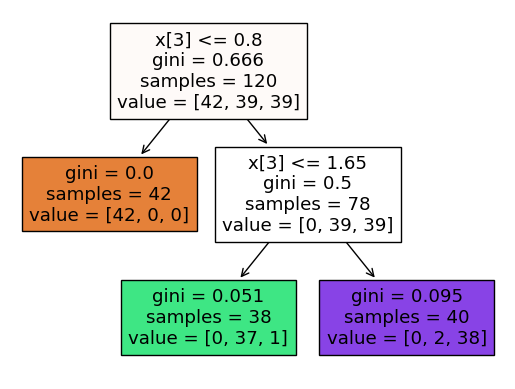

In [9]:
# Define your hyperparameters; vary these
max_depth = 2
min_samples_split = 2
min_samples_leaf = 1


# Define your classifier
clf = tree.DecisionTreeClassifier(max_depth = max_depth,
                                  min_samples_split = min_samples_split,
                                  min_samples_leaf = min_samples_leaf)

# Fit your classifier
clf.fit(X_train, y_train)


# Predict on test data
pred = clf.predict(X_test)
print(accuracy_score(y_test, pred))

# Plot your decision tree
tree.plot_tree(clf, filled = True)

## Summary

In this section, we have covered the basics of decision trees, including:

* Decision tree strucutre: nodes, branches and leaves
* How a decision tree learns data
* How we can apply decision trees to classification and regression

The following section will discuss some common issues with decision trees.

<hr style="border:2px solid gray">

# Section Two: Why not basic Decision Trees?[^](#outline)

So far, so good - decision trees seem like they are powerful and can find good separation between different classes. However, what happens if we let our decision tree get very large? We will illustrate what happens with a regression example, by using a dataset generated using the `make_moons` function in sklearn. We will first generate the data, then plot it. 

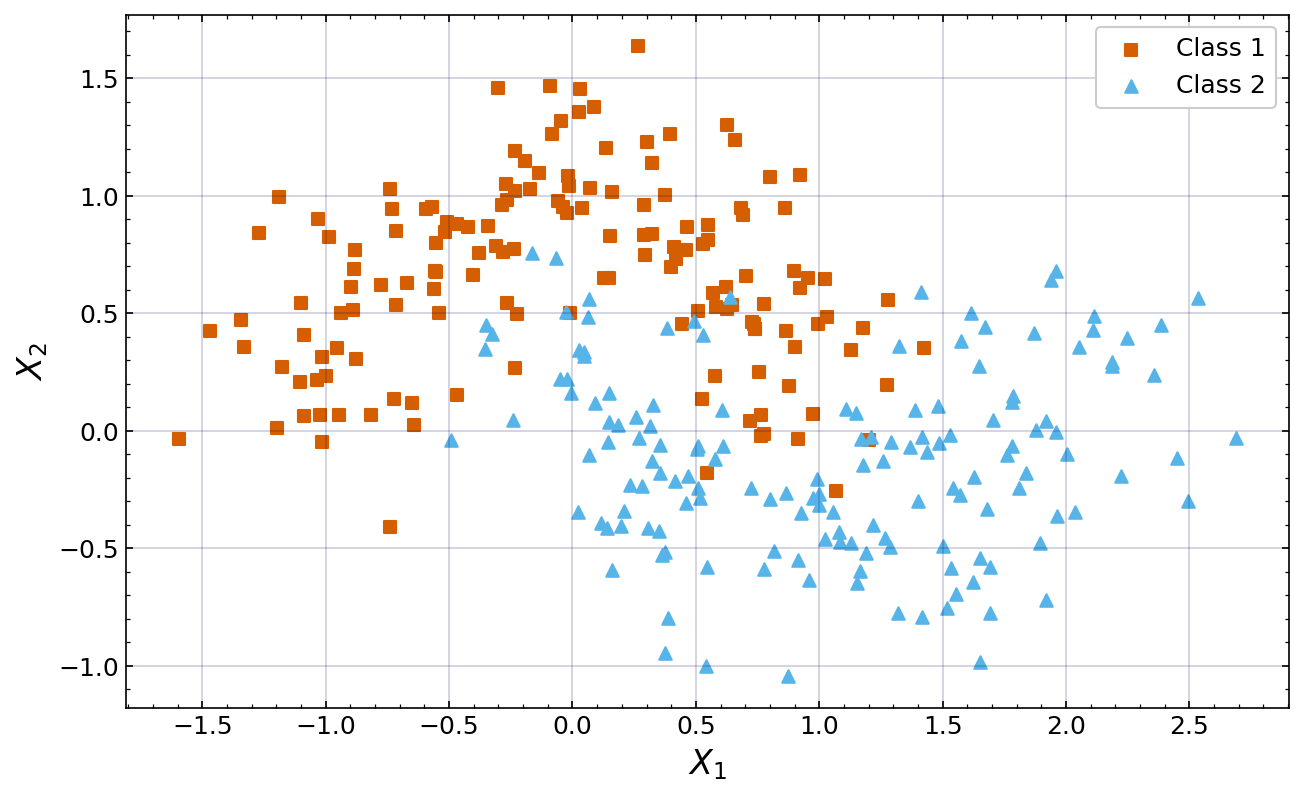

In [10]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples = 300, noise = 0.25, random_state = 42)

fig, ax = plt.subplots(1,1,figsize = (10,6),dpi = 150)
ax.scatter(X[:,0][y==0],X[:,1][y==0],color='#D55E00',marker='s',label= 'Class 1',zorder = 1)
ax.scatter(X[:,0][y==1],X[:,1][y==1],color='#56B4E9',marker='^',label='Class 2',zorder = 1)
ax.set_xlabel('$X_1$',fontsize = 16)
ax.set_ylabel('$X_2$',fontsize = 16)
ax.tick_params(which='both',labelsize= 12,direction='in',top=True,right=True)
ax.grid(color='xkcd:dark blue',alpha = 0.2)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.legend(loc='upper right',fontsize = 12,framealpha = 1)


We will split into train and test datasets, and then train a decision tree with a maximum depth of 200:

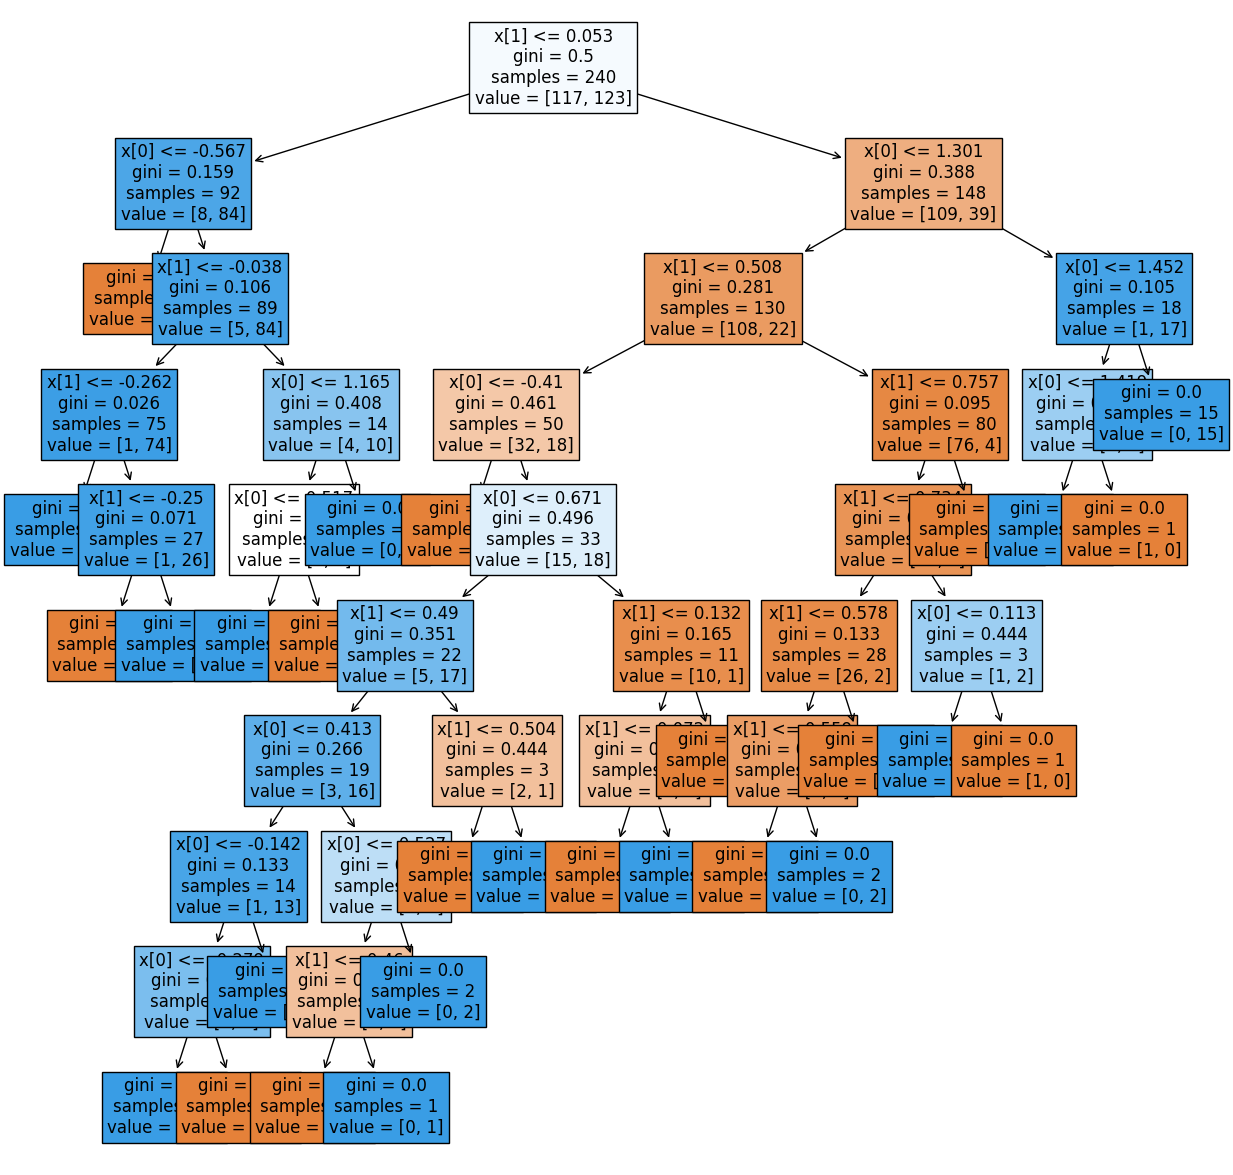

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)

clf = tree.DecisionTreeClassifier(max_depth = 200)
clf.fit(X_train, y_train)

fig = plt.figure(figsize = (15,15))
_ = tree.plot_tree(clf, filled = True, fontsize = 12)


As you can see, this makes a *very* complex decision tree, where many of the nodes have very few samples. We can then plot the decision boundary of the classifier, to see how the decision tree has separated the two classes:

Text(0.5, 1.0, 'Training data')

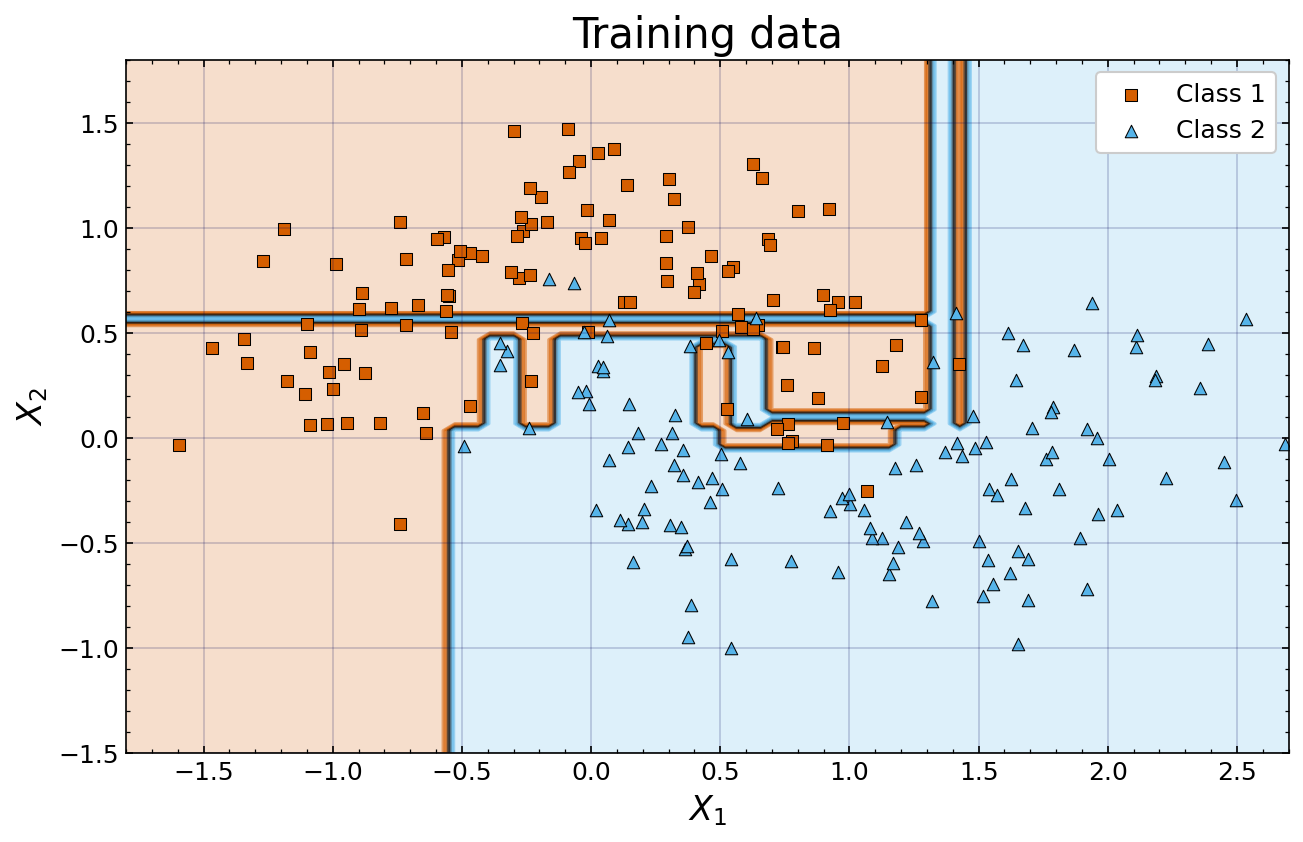

In [29]:
from matplotlib.colors import ListedColormap

x1s, x2s = np.linspace(-1.8,2.7,100), np.linspace(-1.5,1.8,100)
x1, x2 = np.meshgrid(x1s, x2s)
X_new = np.c_[x1.ravel(), x2.ravel()]
y_pred = clf.predict(X_new).reshape(x1.shape)
custom_cmap = ListedColormap(['#D55E00','black','#56B4E9'])

fig, ax = plt.subplots(1,1,figsize = (10,6),dpi = 150)
ax.contourf(x1,x2,y_pred,alpha = 0.2, cmap = custom_cmap,zorder = 0)
ax.contour(x1,x2,y_pred,cmap = custom_cmap,zorder = 0, alpha = 0.5)
ax.scatter(X_train[:,0][y_train==0],X_train[:,1][y_train==0],color='#D55E00',marker='s',label= 'Class 1',zorder = 1,edgecolor='black',lw = 0.5)
ax.scatter(X_train[:,0][y_train==1],X_train[:,1][y_train==1],color='#56B4E9',marker='^',label='Class 2',zorder = 1,edgecolor='black',lw = 0.5)
ax.set_xlabel('$X_1$',fontsize = 16)
ax.set_ylabel('$X_2$',fontsize = 16)
ax.tick_params(which='both',labelsize= 12,direction='in',top=True,right=True)
ax.grid(color='xkcd:dark blue',alpha = 0.2)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.legend(loc='upper right',fontsize = 12, framealpha = 1)
ax.set_title('Training data',fontsize = 20)




You can see that we have a very convoluted decision boundary, which is because of the size of our decision tree. As we add more nodes, the classification criteria become more complex. We can create a decision tree that is *too* large for our dataset, so the training results in a model fitted very well to the training data but without good generalisation. THis is an example of overfitting. 

We can see this by plotting the decision boundary with our test data, and calculating our test accuracy:

Test accuracy = 0.95


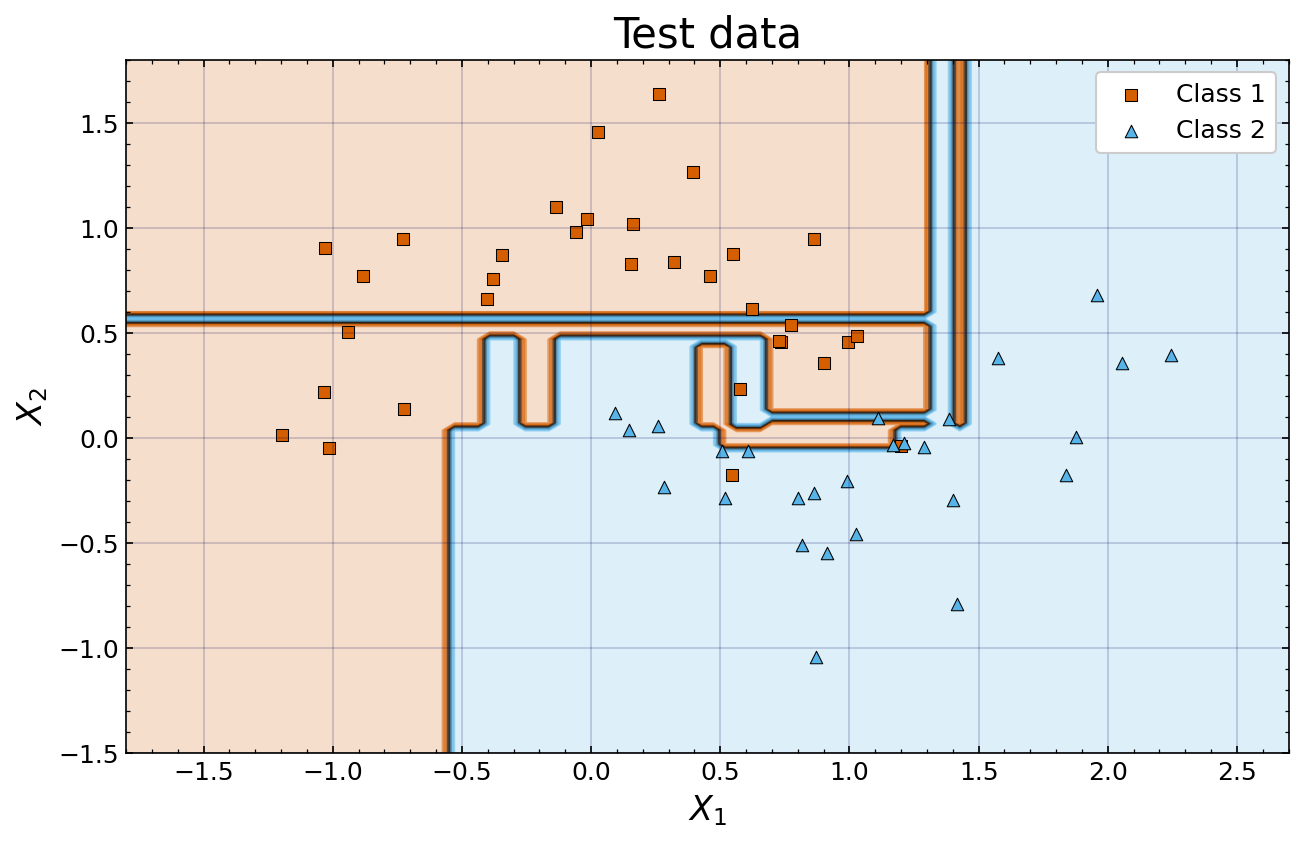

In [30]:
fig, ax = plt.subplots(1,1,figsize = (10,6),dpi = 150)
ax.contourf(x1,x2,y_pred,alpha = 0.2, cmap = custom_cmap,zorder = 0)
ax.contour(x1,x2,y_pred,cmap = custom_cmap,zorder = 0, alpha = 0.5)
ax.scatter(X_test[:,0][y_test==0],X_test[:,1][y_test==0],color='#D55E00',marker='s',label= 'Class 1',zorder = 1,edgecolor='black',lw = 0.5)
ax.scatter(X_test[:,0][y_test==1],X_test[:,1][y_test==1],color='#56B4E9',marker='^',label='Class 2',zorder = 1,edgecolor='black',lw = 0.5)
ax.set_xlabel('$X_1$',fontsize = 16)
ax.set_ylabel('$X_2$',fontsize = 16)
ax.tick_params(which='both',labelsize= 12,direction='in',top=True,right=True)
ax.grid(color='xkcd:dark blue',alpha = 0.2)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.legend(loc='upper right',fontsize = 12, framealpha = 1)
ax.set_title('Test data',fontsize = 20)

print("Test accuracy = {}".format(accuracy_score(y_test,clf.predict(X_test))))

As you can see, some of our test data lies on the wrong side of the boundary. In general, overfitting is a common drawback of decision trees, as the greedy nature of the fitting algorithm chooses the best possible splits every time and so is very optimised to correctly classifying the training dataset. THere are a few things we can do to help this, through regularisation. This includes varying the hyperparameters we have discussed before:

* `max_depth`
* `min_samples_leaf`
* `min_samples_split`

However, in general this is a big issue for decision trees. We can also see how they can result in poor prediction on unseen data by using the MNIST dataset that we saw in Week 7:

In [14]:
# Load the data

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',as_frame = False)

X, y = mnist['data'],mnist['target']

c:\Users\Nick\miniconda3\envs\ML_env\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [15]:
# Split into train/test and train the model

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

clf = tree.DecisionTreeClassifier(max_depth = 20)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=20)

In [16]:
# Predict on test data and calculate prediction accuracy

pred = clf.predict(X_test)
print(accuracy_score(y_test, pred))

0.877


Obviously, this is just with an arbitrary choice of model hyperparameters without any optimisation, but this results in a decision tree that correctly predicts unseen data 88% of the time. There is only so well we can do with a basic decision tree, because of how easy it is for them to overfit to the training data. Instead, we must look to other techniques.



## Summary

In this section, we have briefly seen a very common issue with decision trees:

* Very easy to overfit on training
* Can have poor performance on unseen data

In the following section, we will discuss how we can use so-called **ensemble methods** to overcome these issues with decision trees.

<hr style="border:2px solid gray">

# Section Three: Ensemble Learning and Random Forests[^](#outline)

As we have seen, there is a limit to how well we can do with a single decision tree without overfitting on our training data, and they can often have issues with prediction on unseen data. 

Instead, we can use a technique called **ensemble learning** to improve our prediction. This is when we use *many* individual models (which may be the same type of model or different ones, e.g. a mixture of SVMs and DTs), which make their own independent predictions, and we use some **voting scheme** to determine the ensemble prediction based on the individual predictions of each model. We use different voting schemes for classification and regression, and we can do things in a couple different ways: 

* For classification, we can use either: 
    * Hard voting: the prediction is the most common prediction across all the models
    * Soft voting: the prediction is the most probable prediction across all the models i.e. predicts the class with the greatest total probability across all models in the ensemble
<br>
<br>

* For regression, we can predict either the mean prediction across all models in the ensemble, or a weighted mean. This lets us assign different weights to different models.

In sklearn, default ensemble methods are implemented as `VotingClassifier` and `VotingRegressor` for classification and regression respectively. You can pass a list of different (untrained) models to build the ensemble, as well as specific hyperparameters for each type of ensemble. You can read more about the hyperparameters in the documentation for [classification](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) and [regression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html) respectively. The `VotingClassifier` and `VotingRegressor` otherwise have the same syntax as other ML models in sklearn.

<div style="background-color: #FFF8C6">


## A quick example of ensemble learning

We can demonstrate the power of ensemble learning for the MNIST dataset, using a support vector classifier and a decision tree:

In [17]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

X, y = mnist['data'], mnist['target']
X_train, X_test, y_train, y_test = X[:20000],X[20000:],y[:20000],y[20000:]

In [18]:
svc_clf = SVC(max_iter = 20)
tree_clf = tree.DecisionTreeClassifier(max_depth = 20)

voting_clf = VotingClassifier(estimators = [('svc',svc_clf),('tree',tree_clf)], voting = 'hard')

<div style="background-color: #FFF8C6">


Now we can train each classifier in turn and compare their accuracy, including against the ensemble model. Note: this cell will take a while to run.

In [ ]:
for clf in (svc_clf, tree_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('{} accuracy: {}'.format(clf.__class__.__name__, accuracy_score(y_test, y_pred)))

c:\Users\Nick\miniconda3\envs\ML_env\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC accuracy: 0.83374
DecisionTreeClassifier accuracy: 0.83546


c:\Users\Nick\miniconda3\envs\ML_env\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


VotingClassifier accuracy: 0.85268


<div style="background-color: #FFF8C6">

As you can see, the ensemble classifier has improved performance vs either of the individual classifiers. It is possible to add more models to improve the ensemble, but it will not necessarily improve things (depending on hyperparameters of the individual classifiers etc). 

## Random Forests

When we train an ensemble model out of only decision trees, it is referred to as a **random forest**. Of course, if we just train multiple decision trees on the exact same data we should expect the same performance as the training algorithm should be choosing the (same) best possible splits for each model. Instead, we need to vary the training data given to each model. In general, we do this by taking subsets of the whole training dataset and training each model on a different subset. There are a couple ways we can do this:

* **Bagging**: short for "bootstrap aggregation", refers to taking samples from the training dataset *with replacement*. Each sample in the complete training dataset can be selected more than once for a given individual model training dataset.
<br>

* **Pasting**: rather than replacing training samples after they have been selected, samples are drawn from the complete dataset *without replacement*. Each sample in the complete training dataset can only be selected once for a given individual model training dataset.

In sklearn, random forests are implemented in `sklearn.ensemble` as `RandomForestClassifier` (and `RandomForestRegressor` for regression). 

<div style="background-color:#FFCCCB">

### Validation vs Out of Bag (OOB) Score

We can evaluate the individual classifiers in an ensemble and the whole ensemble in different ways. Consider a single classifier in the ensemble:

* It is trained on a subset of the complete training data
* We call the unused samples from the complete training data (specific to each individual classifier) the **Out of Bag (OOB)** sample. 
* We can evaluate individual classifier performance on its OOB data as it is unseen by that classifier

The OOB accuracy is therefore the fraction of correctly classified data from the OOB samples over all classifiers.

In contrast, we can test the whole ensemble (or individual classifiers) on the test data we set aside before any training. This data is unseen by all of the classifiers and so all classifiers receive the same data for evaluation.

To demonstrate the power of a random forest, we will return to our `make_moons` data from earlier, where we produced a large tree with a very complex decision boundary. Instead, this time we will generate 500 different decision trees, each trained on 100 samples from the training data set. We will use `RandomForestClassifer` from `sklearn.ensemble`, which takes a number of arguments which we can use, as well as all of our normal decision tree arguments (e.g. `max_depth`, `min_samples_split` and `min_samples_leaf`):

* `n_estimators`: the number of different estimators (in this case, decision trees) to train to form the ensemble
<br>

* `max_samples`: the number of samples to use from the training data set for each estimator
<br>

* `bootstrap`: whether to draw with replacement or not. `bootstrap = True` means sampling with replacement.
<br>

* `n_jobs`: number of CPU cores to use during training & prediction. Important when we have lots of estimators/data to speed things up.
<br>

* `oob_score`: whether to calculate the OOB score to test the generalisation of the model

In [23]:
from sklearn.ensemble import RandomForestClassifier

X, y = make_moons(n_samples = 300, noise = 0.25, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)

clf = RandomForestClassifier(n_estimators = 500, 
                             max_samples = 100, 
                             bootstrap = True,
                             n_jobs = 4,
                             oob_score = True,
                             max_leaf_nodes = 20) # Limit individual tree size by requiring no more than 20 leaf nodes

clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=20, n_estimators=500, n_jobs=4,
                       oob_score=True)

Now that we have trained our model, we will evaluate its performance through the OOB score and the accuracy on the training data, as well as plotting the decision boundary:

OOB score = 0.9
Test accuracy = 0.95


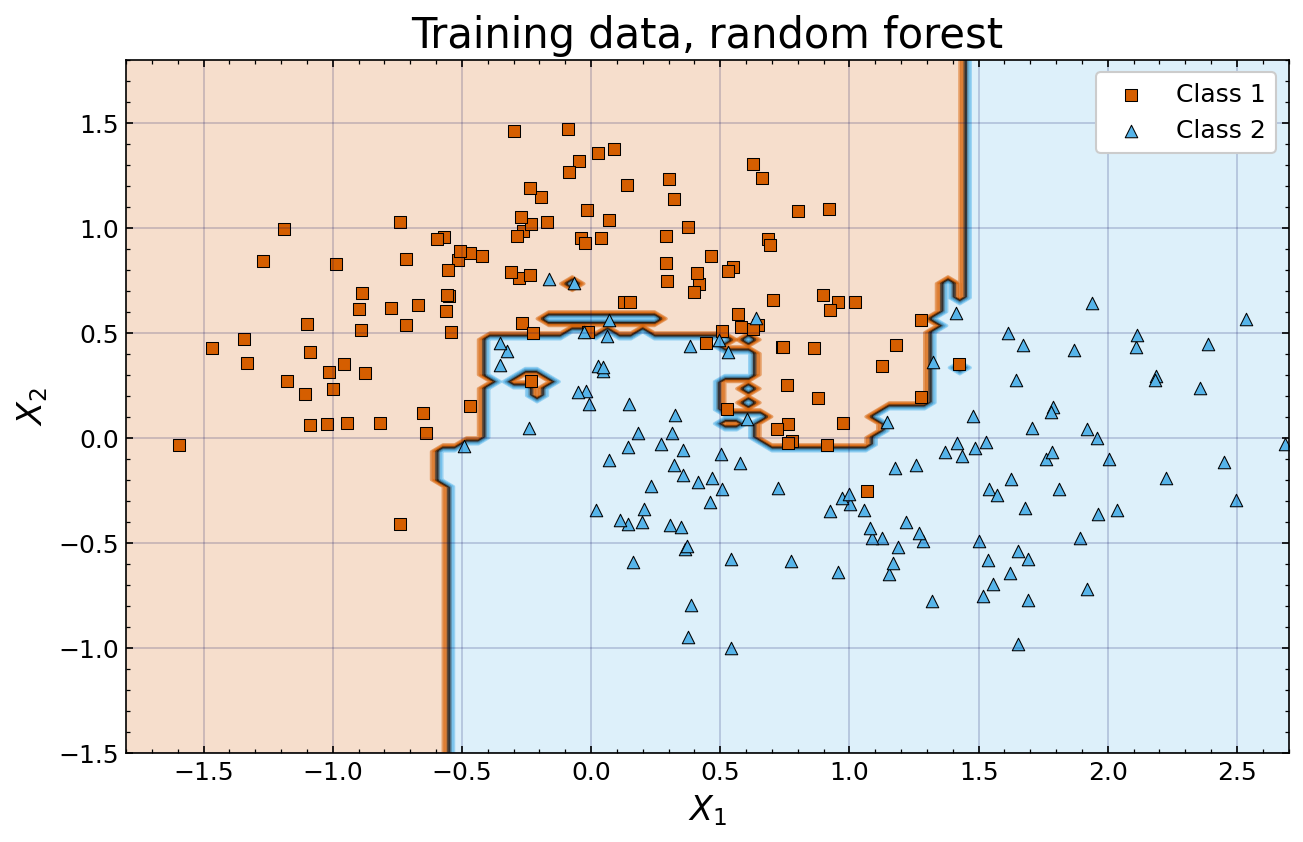

In [24]:
from matplotlib.colors import ListedColormap

x1s, x2s = np.linspace(-1.8,2.7,100), np.linspace(-1.5,1.8,100)
x1, x2 = np.meshgrid(x1s, x2s)
X_new = np.c_[x1.ravel(), x2.ravel()]
y_pred = clf.predict(X_new).reshape(x1.shape)
custom_cmap = ListedColormap(['#D55E00','black','#56B4E9'])

fig, ax = plt.subplots(1,1,figsize = (10,6),dpi = 150)
ax.contourf(x1,x2,y_pred,alpha = 0.2, cmap = custom_cmap,zorder = 0)
ax.contour(x1,x2,y_pred,cmap = custom_cmap,zorder = 0, alpha = 0.5)
ax.scatter(X_train[:,0][y_train==0],X_train[:,1][y_train==0],color='#D55E00',marker='s',label= 'Class 1',zorder = 1,edgecolor='black',lw = 0.5)
ax.scatter(X_train[:,0][y_train==1],X_train[:,1][y_train==1],color='#56B4E9',marker='^',label='Class 2',zorder = 1,edgecolor='black',lw = 0.5)
ax.set_xlabel('$X_1$',fontsize = 16)
ax.set_ylabel('$X_2$',fontsize = 16)
ax.tick_params(which='both',labelsize= 12,direction='in',top=True,right=True)
ax.grid(color='xkcd:dark blue',alpha = 0.2)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.legend(loc='upper right',fontsize = 12, framealpha = 1)
ax.set_title('Training data, random forest',fontsize = 20)

pred = clf.predict(X_test)
print('OOB score = {}'.format(clf.oob_score_))
print('Test accuracy = {}'.format(accuracy_score(y_test,pred)))


While the decision boundary is not perfect, we clearly have a more generalised decision boundary that isn't quite so optimised to the placement of the training data but has more effectively learned the underlying pattern, even though more points may be misclassified. As such, this model should be more successful at predicting unseen data. 

<div style="background-color:#FFCCCB">

It is possible to use this approach with any machine learning model, using `BaggingClassifier` or `BaggingRegressor` from `sklearn.ensemble`. Broadly speaking the approach is the same; you pass the specific classifier you want to use, e.g. SVC or k-NN, and specify how many estimators you want to train and the maximum number of samples for each. You can read more in the documentation for the [classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) and [regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html) respectively.

## Summary

In this section, we have discussed ensemble methods, including:

* How we can make ensembles of different kinds of models
* Bagging and pasting methods for building ensembles
* Random Forests

In the following section, we will discuss another method that builds on ensemble method, called **boosting**. 

<hr style="border:2px solid gray">

# Section Four: Boosted Decision Trees (BDTs)[^](#outline)

Another way that we can combine multiple decision trees is through a technique called **boosting**, which is often more powerful than building random forests. Rather than randomly subsampling our data to train multiple models, we can build an ensemble in a non-random way to try to optmise our performance on unseen data. 

The question that lead to boosting was first posed in 1988, "can a set of weak learners create a single strong learner?" We can define weak and strong learners as follows:

* **Weak learner**: a classifier that is only slightly correlated with the true classification, i.e. performs slightly better than randomly assigning classes
<br>

* **Strong learner**: a classifier that is arbitrarily well-correlated with the true classification, i.e. correctly predicts classes the vast majority of the time



Essentially, the idea is to train a large number of models that are only slightly better than randomly guessing and combine to produce a single ensemble model with accurate prediction. There are many possible boosting algorithms, but we will talk about two in detail and then present one more that is one of the best tools available for training boosted decision trees.

<div style="background-color:#FFCCCB">

## Adaptive Boosting (AdaBoost)

The first boosting algorithm we will discuss is **Adaptive Boosting**, more commonly referred to as **AdaBoost**. An ensemble built using AdaBoost consists of so-called **decision stumps**, decision trees with depth 1 and just two leaves i.e. only 1 data split. The order in which these stumps are created is important; the general process of training an ensemble with AdaBoost is as follows:

* Initially, all training samples are given equal weight (where weights indicate how important it is for a given sample to be classified correctly)
<br>

* A decision stump is found to best classify the training data (remember, only 2 leaves so in the vast majority of cases this cannot be perfect)
<br>

* Any samples that are incorrectly classified are assigned a higher weight, so they are more important to classify correctly for the next estimator. A weight is also generated for the stump itself, based on its total accuracy, so more accurate models are weighted more highly. 
<br>

* The process repeats; a new decision stump is trained to predict the sample data, but this time the samples are not weighted correctly and instead samples that are incorrectly predicted by the first stump are weighted higher, so the new stump emphasises predicting these points correctly.
<br>

This process repeats iteratively, adding more stumps trained to emphasise correct prediction on points that were previously predicted incorrectly, until either all of the data has been correctly classified or until the maximum number of repetitions has been met. 

The final prediction of the ensemble is the weighted combination of the predictions from each decision stump. 

In sklearn, AdaBoost is implemented in `sklearn.ensemble` as `AdaBoostClassifier` (or `AdaBoostRegressor` for regression, where instead of classification accuracy we calculate the error e.g. mean squared error between prediction and target values). You can read more in the [documentation](https://scikit-learn.org/stable/modules/ensemble.html#adaboost).

<div style="background-color: #FFF8C6">

### Mathematics of AdaBoost Classification

When we use the AdaBoost algorithm for classification, we initially assign an equal weight to each of our $N$ training points, such that 

\begin{equation*}
w_i = \frac{1}{N},
\end{equation*}
where $w_i$ is the weight for the $i$-th training point. 

Then, we train a decision stump to predict our training data. After the model is trained, we define the total error $\epsilon$ according to 

\begin{equation*}
\epsilon = \sum_{\hat{y}_i \neq y_i} w_i,
\end{equation*}
where the sum is over the samples $y_i$ where the prediction $\hat{y}_i$ is incorrect i.e. have received the *wrong* classification.

We can then define the **amount of say** of the model, according to

\begin{equation*}
\alpha = \frac{1}{2}\ln\left(\frac{1 - \epsilon}{\epsilon}\right)
\end{equation*}

This tells us how much 'say' this stump has in prediction in the final model. For very accurate models ($\epsilon$ close to 0) the amount of say is very large and positive, whereas for very inaccurate models ($\epsilon \gg 0$) it is very large and negative. If the stump performs similarly to just guessing randomly ($\epsilon = 0.5$) then $\alpha$ will be close to 0. 

After training each stump, the sample weights must be updated. The update to the $i$-th weight after training the $j$-th decision stump is given as

\begin{align*}
w_{i}^{j+1} &= w_i^{j}e^{+\alpha^j}, \qquad \hat{y}_i^j \neq y_i \\
w_{i}^{j+1} &= w_i^{j}e^{-\alpha^j}, \qquad \hat{y}_i^j = y_i
\end{align*}
where $w_i^j$ denotes the weight for sample $i$ before training stump $j$, $w_i^{j+1}$ denotes the weight for sample $i$ after training stump $j$, $\alpha^j$ denotes the amount of say for stump $j$, and $\hat{y}_i^j$ denotes the prediction of stump $j$ for sample $i$. 

After updating the weights, they are normalised such that $\hat{w_i} = w_i/\sum_i w_i$. The process of creating new decision stumps then continues in this way with the new weighting until all of the data has been classified correctly or we have reached the maximum number of repeats.

<div style="background-color:#FFCCCB">

## Gradient boosting

Another common boosting algorithm is **gradient boosting**. In this algorithm, we define some *differentiable* loss function $L(y, F(X))$ for some model prediction $F(X)$ and true value $y$. 

This conceptually works by: 

* First initialising the strong model to predict a constant value (either a class or specific function value) for all inputs
<br>

* Calculating the gradient of the loss function with respect to the predicted values. These gradients are referred to as the **pseudo-residuals**. 
<br>

* After we calculate the pseudo-residuals, we train a weak learner to predict them, e.g. some decision tree, to predict the gradient of the strong model loss function.
<br>

* Subtract the new weak learner from the strong learner, so we "step" in the direction of negative gradient. This is similar to the gradient descent algorithm we briefly touched on in Week 4 - if we step in the opposite direction of the gradient, we step towards the minimum of the loss function
<br>

* The process of calculating pseudo-resdiuals and training weak learners continues until some stopping criterion is met, e.g. the value of the loss function is sufficiently small.

Of course, we can always be in danger of overfitting. To combat this, we can use a learning rate or **shrinkage** $\nu$ to control how quickly we step in the direction of the gradient. In general, taking many small steps in the direction of the negative gradient should result in better predictions with a lower variance. 

<div style="background-color: #FFF8C6">

### Mathematics for gradient boosted models

Consider some differentiable loss function $L(y, F(x))$ for some true target $y$ and model prediction $F(X)$ for input $X$. We initialise the model to some constant value, typically the single prediction value $\gamma$ that gives the minimum possible loss for all target values $\{y_i\}$. We write this as

\begin{equation*}
F_0(X) = \sum_{i = 1}^N L(y_i, \gamma), 
\end{equation*}
where $F_0(X)$ denotes the $0$-th iteration of our strong learner i.e. the starting value.

We denote the maximum number of iterations as $M$, then for $m = 1$ to $M$:

1. Compute the psuedo-residuals
\begin{equation*}
r_{im} = -\left[\frac{\partial L(y_i, F(X_i))}{\partial F(X_i)}\right]_{F(X) = F_{m - 1}(X)}\quad \text{for }i = 1,\cdots, n
\end{equation*}

1. Fit a weak learner $h_m(X)$ to predict the pseudo-residuals, i.e. train using the training set $\{(x_i, r_{im})\}_{i = 1}^N$

1. Calculate a multplier $\gamma_m$ to convert weak model prediction from gradient to value, such that $\gamma_m$ minimises the loss, i.e. solving the following optimisation problem:
\begin{equation*}
\gamma_m = \argmin_\gamma \sum_{i = 1}^N L(y_i, F_{m - 1}(X_i) + \gamma h_m(X_i)),
\end{equation*}
where $\argmin_\gamma$ means find the value of the argument $\gamma$ that minimises the function. This will in general be negative to minimise the loss.

1. Update the model with our new weak model, its multiplier, and our shrinkage:

\begin{equation*}
F_m(X) = F_{m - 1}(X) + \nu \gamma_m h_m(X)
\end{equation*}

After reaching $M$ iterations, we output the model $F_M(X)$.

## XGBoost

Both AdaBoost and gradient boosting are available in `sklearn.ensemble` as `AdaBoostClassifier`/`AdaBoostRegressor` and `GradientBoostingClassifier`/`GradientBoostingRegressor` respectively. You can find more details about both of these methods in **{homl}**. However, one of the best tools available is [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html), which is an abbreviation of e**X**treme **G**radient **Boost**. This is a complex algorithm based on gradient boosting that we will not explain here; you can read more in the XGBoost [documentation](https://xgboost.readthedocs.io/en/stable/tutorials/model.html). 



The `xgboost` module is the Python library we need to use the XGBoost algorithm; it is designed to use the same syntax as `sklearn`, so using it should be straightforward now you have seen several different algorithms in sklearn with the same (or similar) syntax. We will try a simple example using the `make_moons` data below to demonstrate the use of XGBoost.

Accuracy = 0.9666666666666667


Text(0.5, 1.0, 'Training data, XGBoost')

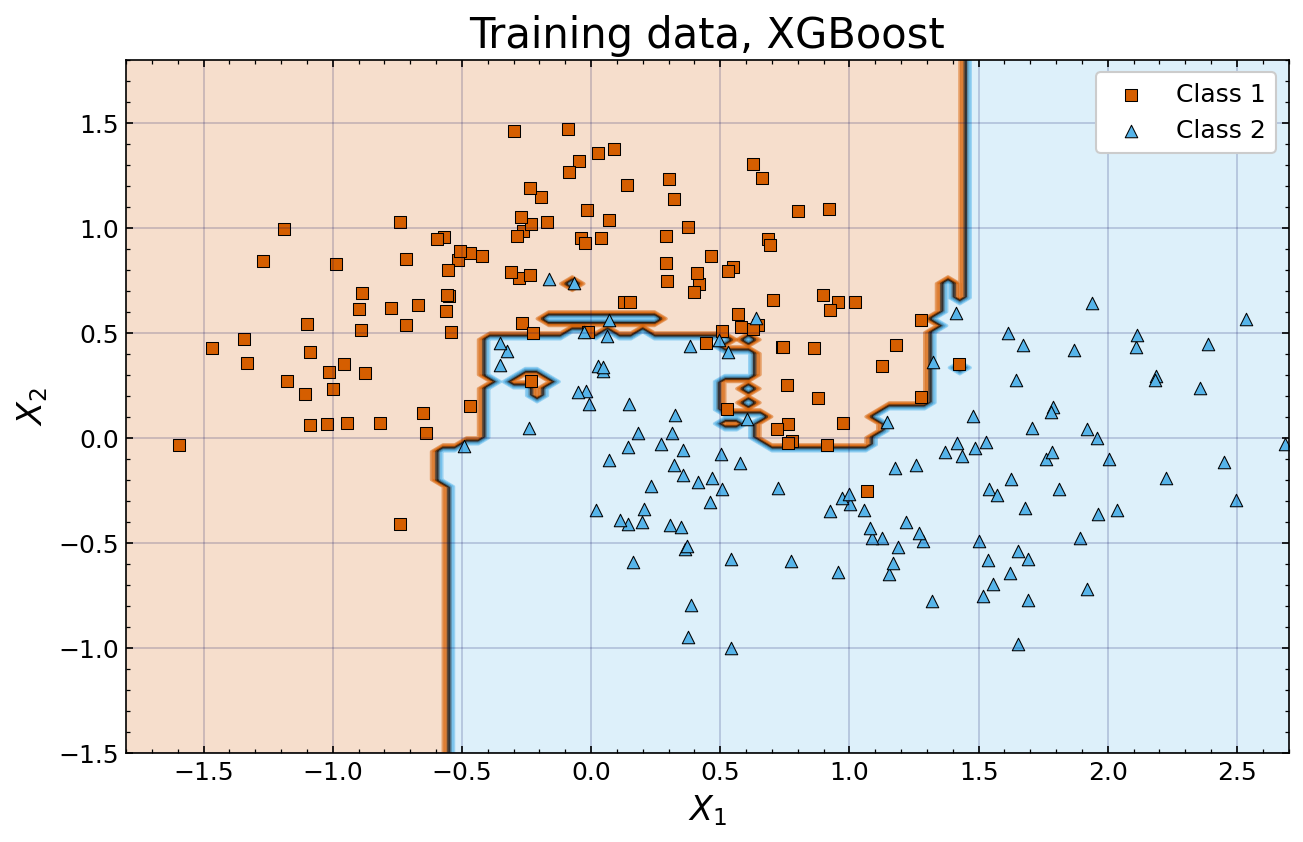

In [26]:
from xgboost import XGBClassifier

X, y = make_moons(n_samples = 300, noise = 0.25, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)

clf = XGBClassifier()
clf.fit(X_train, y_train)

pred = clf.predict(X_test)

print("Accuracy = {}".format(accuracy_score(y_test, pred)))

fig, ax = plt.subplots(1,1,figsize = (10,6),dpi = 150)
ax.contourf(x1,x2,y_pred,alpha = 0.2, cmap = custom_cmap,zorder = 0)
ax.contour(x1,x2,y_pred,cmap = custom_cmap,zorder = 0, alpha = 0.5)
ax.scatter(X_train[:,0][y_train==0],X_train[:,1][y_train==0],color='#D55E00',marker='s',label= 'Class 1',zorder = 1,edgecolor='black',lw = 0.5)
ax.scatter(X_train[:,0][y_train==1],X_train[:,1][y_train==1],color='#56B4E9',marker='^',label='Class 2',zorder = 1,edgecolor='black',lw = 0.5)
ax.set_xlabel('$X_1$',fontsize = 16)
ax.set_ylabel('$X_2$',fontsize = 16)
ax.tick_params(which='both',labelsize= 12,direction='in',top=True,right=True)
ax.grid(color='xkcd:dark blue',alpha = 0.2)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.legend(loc='upper right',fontsize = 12, framealpha = 1)
ax.set_title('Training data, XGBoost',fontsize = 20)

As you can see from the test classification accuracy, this has outperformed not only our single decision tree that we trained in Section Two, but also the Random Forest we trained in Section Three. There are many parameters for XGBoost that you can try and train, which you are encouraged to look at, for the [classifier](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier) and [regressor](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor) respectively.

## Summary

In this section, we have introduced boosting algorithms for decision trees, including:

* AdaBoost
* Gradient boosting
* XGBoost

The following section will cover the exercises for you to work through this week.

<hr style="border:2px solid gray">

# Section Five: Exercises[^](#outline)

<div style="background-color:#C2F5DD">

## Decision tree classification on toy data

## Exercise 1

First, you will use a simple decision tree on the `make_moons` data we showed earlier to try to get the best classification performance you can. Try varying the hyperparameters of the decision tree, including:

* `max_depth`
* `min_samples_leaf`
* `min_samples_node`

See the sklearn [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) for other hyperparameters you can vary. Make sure you record what hyperparameters you vary.

Remember the following steps: 

* Split the data into train and test datasets
* Define your hyperparameters
* Initialise your model
* Fit your model to the training data
* Calculate accuracy of test prediction

In [ ]:
# Prepare the data
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier

X, y = make_moons(n_samples = 300, noise = 0.25, random_state = 42)


In [ ]:
# Split into train and test datasets

X_train, X_test, y_train, y_test = 


In [ ]:
# Define your hyperparameters


# Define your model

clf = 


In [ ]:
# Fit your model to the training data



In [ ]:
# Evaluate model performance on test data

from sklearn.metrics import accuracy_score

pred = 

accuracy = 



Your answer here

<div style="background-color:#C2F5DD">

## Exercise 2

Now you have tried a basic decision tree, try fitting the same data using a random forest. Use class `RandomForestClassifier` from `sklearn.ensemble`. Again, vary your hyperparmeters to find the best performance you can, including:

* `max_depth`
* `n_estimators`
* `min_samples_split`
* `min_samples_leaf`

Check the sklearn [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for `RandomForestClassifier` for details of other hyperparameters you can vary.

Remember the following steps:

* Define your hyperparameters
* Define your model
* Fit your model to the training data
* Predict on the test data and calculate the classification accuracy, as well as the OOB score


In [ ]:
# Define hyperparameters



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define model



In [ ]:
# Fit model



In [ ]:
# Calculate accuracy on test data



<div style="background-color:#C2F5DD">

What hyperparameters give your best performance? Write your answer in the Markdown cell below.



Your answer here

<div style="background-color:#C2F5DD">

## Exercise 3

Finally, try fitting the `make_moons` data using XGBoost, using `XGBoostClassifier`. The hyperparameters of this algorithm are a bit different to the sklearn implementations, but the syntax is otherwise very similar for fitting and predicting. A few hyperparameters in particular to look at include:

* `max_depth`
* `max_leaves`
* `learning_rate`

You can read about more hyperparameters in the [documentation](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier).

Remember the following steps to train your model: 

* Define your hyperparameters
* Define your model
* Fit your model
* Evaluate the model performance on test data



In [ ]:
# Define hyperparameters



In [ ]:
from xgboost import XGBoostClassifier

# Define model



In [ ]:
# Fit model



In [ ]:
# Predict on test data



<div style="background-color:#C2F5DD">

What hyperparameters give you your best performance? How does your XGBoost result compare to your single decision tree and RandomForest results? Are the comparable hyperparameters (e.g. `max_depth`) that give the best performance the same between each model? Why/why not? Write your answers in the Markdown cell below.

Your answer here

<div style="background-color:#C2F5DD">

## Decision trees for regression with toy data

## Exercise 4

We will use the toy regression data we generated earlier in this notebook to experiment with using decision trees for regression. Start by using `DecisionTreeRegressor` from `sklearn.tree`. Try varying hyperparameters to get the best possible performance you can, including:

* `criterion`: the function measuring the quality of the split, e.g. mean squared error, absolute error, etc.
* `max_depth`
* `min_samples_depth`

You can read more about possible hyperparameters in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html).

Remember the following steps:

* Split your dataset into train and test datasets
* Define your hyperparameters
* Define your model
* Fit your model
* Calculate prediction on test data and calculate performance metrics e.g. mean squared error or coefficient of determination (by default, `DecisionTreeRegressor.score` calculates the coefficient of determination). Refer to the Week 7 notebook for possible regression performance metrics.

Remember to record the hyperparameters that give the best performance. 

In [ ]:
# Define dataset

np.random.seed(42) # Set the seed for consistency

X = 6*np.random.rand(1000,1) - 3
y = 0.5*X**2 + X + 2 + np.random.randn(1000,1)

In [ ]:
# Split dataset into train and test datasets

X_train, X_test, y_trian, y_test = 


In [ ]:
# Define hyperparameters



In [ ]:
# Define model



In [ ]:
# Fit model



In [ ]:
# Calculate prediction on test data and performance metrics



<div style="background-color:#C2F5DD">

What hyperparameters give your best performance? Write your answers in the Markdown cell below.

Your answer here

<div style="background-color:#C2F5DD">

## Exercise 5

This time, try using a random forest to fit the data, using `RandomForestRegressor`, varying the hyperparameters to find the best performance you can. Try varying the following hyperparameters:

* `criterion`
* `max_depth`
* `n_estimators`
* `min_samples_split`
* `min_samples_leaf`

Remember the following steps:

* Define your hyperparameters
* Define your model
* Fit your model
* Calculate prediction on test data and regression performance metrics of your choice

Make sure to record what hyperparameters give you the best performance. 

In [ ]:
# Define your hyperparameters



In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Define your model



In [ ]:
# Fit your model



In [ ]:
# Predict on test data and calculate performance metrics



<div style="background-color:#C2F5DD">

What hyperparameters give your best performance? Write your answers in the Markdown cell below.

Your answer here

<div style="background-color:#C2F5DD">

## Exercise 6

Finally, try training a regression tree using XGBoost, using the `XGBoostRegressor` class. Vary hyperparameters to find the best possible performance you can. Try varying the following hyperparameters:

* `max_depth`
* `max_leaves`
* `learning_rate`

You can find other options of hyperparameters to vary in the [documentation](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor). Make sure to record what parameters you vary.

Remember the following steps:

* Define your hyperparameters
* Define your model
* Fit your model
* Make predictions on test data and calculate performance metrics of your choice

In [ ]:
# Define hyperparameters



In [ ]:
from xgboost import XGBoostRegressor

# Define your model



In [ ]:
# Fit your model



In [ ]:
# Calculate prediction and performance metrics of your choice



<div style="background-color:#C2F5DD">


What hyperparameters give you your best performance? How does your XGBoost result compare to your single decision tree and RandomForest results? Are the comparable hyperparameters (e.g. `max_depth`) that give the best performance the same between each model? Why/why not? Write your answers in the Markdown cell below.

Your answer here

<div style="background-color:#C2F5DD">

## Decision tree classification for the MNIST dataset

## Exercise 7

For the last set of exercises, we will use decision trees on the MNIST dataset. We first need to load the data:

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',as_frame = False)

X, y = mnist['data'], mnist['target']

<div style="background-color:#C2F5DD">

First using a `DecisionTreeClassifier`, train a model on the MNIST dataset to classify the points. Try varying your hyperparameters to get the best possible performance on test data. Hyperparameters to try varying include:

* `max_depth`
* `min_samples_leaf`
* `min_samples_split`

As always, feel free to vary any other hyperparameters of the model, which you can find descriptions of in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier).

Remember the following steps:

* Split your data into train and test datasets
* Define your hyperparameters
* Define your model
* Fit your model
* Calculate prediction on test data and calculate classification accuracy

In [ ]:
# Split data into train and test datasets



In [ ]:
# Define your hyperparameters



In [ ]:
# Define your model



In [ ]:
# Fit your model



In [ ]:
# Calculate prediction on test data and test accuracy



<div style="background-color:#C2F5DD">
 What hyperparameters give you the best performance on the test data? Write your answer in the Markdown cell below.


Your answer here


<div style="background-color:#C2F5DD">

## Exercise 8

Repeat the same exercise, but this time using a random forest (via `RandomForestClassifier`). Vary your hyperparameters to find the best possible test accuracy you can.

Remember the following steps:

* Define your hyperparameters
* Define your model
* Fit your model
* Calculate prediciton on test data and test accuracy

Record what hyperparameter values you vary and the performance for each combination.

In [ ]:
# Define your hyperparameters



In [ ]:
# Define your model



In [ ]:
# Fit your model



In [ ]:
# Calculate prediction on test data and test accuracy



<div style="background-color:#C2F5DD">

What combination of hyperparameters gave you the best performance? Write your answer in the Markdown cell below.

Your answer here

<div style="background-color:#C2F5DD">

## Exercise 9

Finally, using `XGBoostClassifier`, train a model on the MNIST dataset. Vary your hyperparameters to find the best possible test accuracy you can.

Remember the following steps:

* Define your hyperparameters
* Define your model
* Fit your model
* Calculate prediciton on test data and test accuracy

Record what hyperparameter values you vary and the performance for each combination.

In [ ]:
# Define your hyperparameters



In [ ]:
# Define your model



In [ ]:
# Fit your model



In [ ]:
# Calculate prediction on test data and test accuracy



<div style="background-color:#C2F5DD">


What hyperparameters give you your best performance? How does your XGBoost result compare to your single decision tree and RandomForest results? Are the comparable hyperparameters (e.g. `max_depth`) that give the best performance the same between each model? Why/why not? Write your answers in the Markdown cell below.

Your answer here